In [15]:
%%capture
%load_ext autoreload
%autoreload 2
from setup_nb_env import *

from epsampling.utils import load_csv
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from epsampling.utils import drop_sers_with_nans
from epsampling.utils import date_str_to_int

DATA_DIR = '/work/users/k/4/k4thryn/Repos/EpSampling/data/'
DT = datetime.today().strftime('%Y%m%d-%H%M%S')

from IPython.display import Audio

def meow():
    display(Audio(filename='../cat_meow2.wav', autoplay=True))

In [16]:
ts = '20241106-112904'
fpath = os.path.join(DATA_DIR,'processed',f'training_target_df_{ts}.csv')
df = pd.read_csv(fpath)
fpath = os.path.join(DATA_DIR,'processed',f'training_acs_df_{ts}.csv')
df_acs = pd.read_csv(fpath)
df_acs.set_index('Fips',inplace=True,drop=True)
# standardize
df_acs = (df_acs-df_acs.mean()) / df_acs.std()

### <font color=blue> Transform target variables.

In [17]:
county_transform = ['True_county_inc_deaths','Naive_proj_deaths','Naive_true_deaths']
for var in county_transform:
    df[f'{var}_x'] = df.apply(lambda x: (x[var]+1) / x.Pop * 100000, axis=1)
    
state_transform = ['Proj_state_inc_deaths','True_state_inc_deaths']
for var in state_transform:
    df[f'{var}_x'] = df.apply(lambda x: (x[var]+1) / x.State_pop * 100000, axis=1)
    
df

,Date,State_fips,Fips,Pop,State_pop,Ratio,Proj_state_inc_deaths,True_state_inc_deaths,True_county_cum_deaths,True_county_inc_deaths,Naive_proj_deaths,Naive_true_deaths,True_county_inc_deaths_x,Naive_proj_deaths_x,Naive_true_deaths_x,Proj_state_inc_deaths_x,True_state_inc_deaths_x
0,20200620,37,37001,169185,10367022,0.016,122.952,104.000,35.000,3.000,2.007,1.697,2.364,1.777,1.594,1.196,1.013
1,20200627,37,37001,169185,10367022,0.016,100.309,95.000,36.000,1.000,1.637,1.550,1.182,1.559,1.507,0.977,0.926
2,20200704,37,37001,169185,10367022,0.016,119.399,80.000,37.000,1.000,1.949,1.306,1.182,1.743,1.363,1.161,0.781
3,20200711,37,37001,169185,10367022,0.016,100.119,106.000,37.000,0.000,1.634,1.730,0.591,1.557,1.614,0.975,1.032
4,20200718,37,37001,169185,10367022,0.016,120.176,133.000,39.000,2.000,1.961,2.170,1.773,1.750,1.874,1.169,1.293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9895,20220409,37,37199,18357,10367022,0.002,55.000,43.000,51.000,0.000,0.097,0.076,5.448,5.978,5.862,0.540,0.424
9896,20220416,37,37199,18357,10367022,0.002,41.000,76.000,51.000,0.000,0.073,0.135,5.448,5.843,6.181,0.405,0.743
9897,20220423,37,37199,18357,10367022,0.002,60.000,29.000,51.000,0.000,0.106,0.051,5.448,6.026,5.727,0.588,0.289
9898,20220430,37,37199,18357,10367022,0.002,33.000,42.000,51.000,0.000,0.058,0.074,5.448,5.766,5.853,0.328,0.415


In [18]:
df = df.merge(df_acs,on='Fips',suffixes=('', '_s'))
# df.drop(df.filter(regex='_s$').columns, axis=1, inplace=True)

In [19]:
# target_col = 'True_county_inc_deaths_x'
# naive_col = 'Naive_proj_deaths_x'
# # naive_col = 'True_county_inc_deaths_x'
# base_pred_col = 'True_state_inc_deaths_x'

# feats =  [base_pred_col] + [x for x in df_acs.columns] 

### <font color=blue> Train model using true state deaths as covariate.

In [35]:
%precision %.2f
pd.set_option('display.float_format', '{:.2f}'.format)
np.set_printoptions(suppress=True) # don't use scientific notation

from epsampling.utils import get_chunks
from epsampling.modeling import get_date_chunked_splits, get_performance
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
random.seed(666)

from tqdm.notebook import tqdm


target_col = 'True_county_inc_deaths_x'

num_weeks_in_chunk = 4
num_runs = 25
alg = 'LinReg'

chunks = get_chunks(list(df.Date.unique()), num_weeks_in_chunk)
idc = random.sample(range(len(chunks)), num_runs)

test_dfs = []
models = {}

for i,idx in tqdm(enumerate(idc), total=len(idc)):
    
    df_train, df_test = get_date_chunked_splits(df, chunks, idx)
        
    df_test[f'Run'] = i

    for base_pred_col in ['True_state_inc_deaths_x','Proj_state_inc_deaths_x']:
        
        feats =  [base_pred_col] + [x for x in df_acs.columns] 
        X_train = df_train[feats]
        y_train = df_train[target_col]

        X_test = df_test[feats]

        reg = LinearRegression().fit(X_train, y_train)

        df_test[f'{alg}_({base_pred_col})'] = reg.predict(X_test)
        

    test_dfs.append(df_test)
    models[i] = reg

  0%|          | 0/25 [00:00<?, ?it/s]

In [21]:
# %precision %.2f
# pd.set_option('display.float_format', '{:.2f}'.format)
# np.set_printoptions(suppress=True) # don't use scientific notation

# from epsampling.utils import get_chunks
# from epsampling.modeling import get_date_chunked_splits, get_performance
# from sklearn import linear_model
# from sklearn.linear_model import LinearRegression
# random.seed(666)

# from tqdm.notebook import tqdm

# target_col = 'True_county_inc_deaths_x'
# alg = 'LinReg'

# for base_pred_col in ['True_state_inc_deaths_x','Proj_state_inc_deaths_x']:

#     feats =  [base_pred_col] + [x for x in df_acs.columns] 
#     X_train = df[feats]
#     y_train = df[target_col]

#     reg = LinearRegression().fit(X_train, y_train)

#     df[f'{alg}_({base_pred_col})'] = reg.predict(X_train)

In [36]:
df

,Date,State_fips,Fips,Pop,State_pop,Ratio,Proj_state_inc_deaths,True_state_inc_deaths,True_county_cum_deaths,True_county_inc_deaths,...,HU_x15,HU_UIS01D,HU_UIS01A,HU_UIS02,HU_UIS0304,HU_UIS0509,HU_UIS1019,HU_UIS2049,HU_UIS50P,HU_UISOTHER
0,20200620,37,37001,169185,10367022,0.02,122.95,104.00,35.00,3.00,...,0.37,-0.23,0.66,0.16,1.08,1.26,0.81,1.26,0.14,-0.89
1,20200627,37,37001,169185,10367022,0.02,100.31,95.00,36.00,1.00,...,0.37,-0.23,0.66,0.16,1.08,1.26,0.81,1.26,0.14,-0.89
2,20200704,37,37001,169185,10367022,0.02,119.40,80.00,37.00,1.00,...,0.37,-0.23,0.66,0.16,1.08,1.26,0.81,1.26,0.14,-0.89
3,20200711,37,37001,169185,10367022,0.02,100.12,106.00,37.00,0.00,...,0.37,-0.23,0.66,0.16,1.08,1.26,0.81,1.26,0.14,-0.89
4,20200718,37,37001,169185,10367022,0.02,120.18,133.00,39.00,2.00,...,0.37,-0.23,0.66,0.16,1.08,1.26,0.81,1.26,0.14,-0.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9895,20220409,37,37199,18357,10367022,0.00,55.00,43.00,51.00,0.00,...,-0.50,0.64,-0.63,-0.59,0.81,-0.52,-0.45,-0.31,-0.66,0.02
9896,20220416,37,37199,18357,10367022,0.00,41.00,76.00,51.00,0.00,...,-0.50,0.64,-0.63,-0.59,0.81,-0.52,-0.45,-0.31,-0.66,0.02
9897,20220423,37,37199,18357,10367022,0.00,60.00,29.00,51.00,0.00,...,-0.50,0.64,-0.63,-0.59,0.81,-0.52,-0.45,-0.31,-0.66,0.02
9898,20220430,37,37199,18357,10367022,0.00,33.00,42.00,51.00,0.00,...,-0.50,0.64,-0.63,-0.59,0.81,-0.52,-0.45,-0.31,-0.66,0.02


In [37]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

df_res = pd.concat(test_dfs)
df_res.drop(df_acs.columns,axis=1,inplace=True)
df_res

,Date,State_fips,Fips,Pop,State_pop,Ratio,Proj_state_inc_deaths,True_state_inc_deaths,True_county_cum_deaths,True_county_inc_deaths,Naive_proj_deaths,Naive_true_deaths,True_county_inc_deaths_x,Naive_proj_deaths_x,Naive_true_deaths_x,Proj_state_inc_deaths_x,True_state_inc_deaths_x,Run,LinReg_(True_state_inc_deaths_x),LinReg_(Proj_state_inc_deaths_x)
56,20210717,37,37001,169185,10367022,0.0163,40.0000,37.0000,288.0000,0.0000,0.6528,0.6038,0.5911,0.9769,0.9480,0.3955,0.3665,0,0.9008,1.4198
57,20210724,37,37001,169185,10367022,0.0163,45.0000,53.0000,288.0000,0.0000,0.7344,0.8649,0.5911,1.0251,1.1023,0.4437,0.5209,0,1.0960,1.4722
58,20210731,37,37001,169185,10367022,0.0163,54.0000,65.0000,288.0000,0.0000,0.8813,1.0608,0.5911,1.1120,1.2181,0.5305,0.6366,0,1.2424,1.5664
59,20210807,37,37001,169185,10367022,0.0163,78.0000,101.0000,288.0000,0.0000,1.2729,1.6483,0.5911,1.3435,1.5653,0.7620,0.9839,0,1.6816,1.8176
155,20210717,37,37003,36491,10367022,0.0035,40.0000,37.0000,84.0000,0.0000,0.1408,0.1302,2.7404,3.1262,3.0973,0.3955,0.3665,0,4.1938,4.7128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9709,20200808,37,37197,37198,10367022,0.0036,162.0000,195.0000,6.0000,0.0000,0.5813,0.6997,2.6883,4.2510,4.5693,1.5723,1.8906,24,5.4142,5.2674
9805,20200718,37,37199,18357,10367022,0.0018,120.1763,133.0000,0.0000,0.0000,0.2128,0.2355,5.4475,6.6067,6.7304,1.1689,1.2926,24,7.4094,7.6044
9806,20200725,37,37199,18357,10367022,0.0018,131.0000,148.0000,0.0000,0.0000,0.2320,0.2621,5.4475,6.7111,6.8751,1.2733,1.4372,24,7.5920,7.7177
9807,20200801,37,37199,18357,10367022,0.0018,152.0000,188.0000,0.0000,0.0000,0.2691,0.3329,5.4475,6.9137,7.2610,1.4758,1.8231,24,8.0783,7.9384


In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error

def get_metrics_ser(df, target_col, pred_col):
    
    metrics_dict = {'MAE': mean_absolute_error,
                    'MedAE': median_absolute_error,
                    'MSE': mean_squared_error,
                    'RMSE': mean_squared_error,
                    'r2': r2_score
                    }
    
    mae = mean_absolute_error(df[target_col], df[pred_col])
    medae = median_absolute_error(df[target_col], df[pred_col])
    r2 = r2_score(df[target_col], df[pred_col])
    mse = mean_squared_error(df[target_col], df[pred_col])
    
    # relMAE to naive_true
    relmae_true = mae / mean_absolute_error(df[target_col],df['Naive_true_deaths_x'])
    # relMAE to naive_proj
    relmae_proj = mae / mean_absolute_error(df[target_col],df['Naive_proj_deaths_x'])
    
    ser = {'Model':pred, 'MAE':mae, 'MedAE':medae, 
           'R-squared':r2, 'MSE': mse, 'relMAE (Proj)': relmae_proj, 
           'relMAE (True)': relmae_true}
    
    return ser
    
    
metrics_sers = []

for pred in ['LinReg_(True_state_inc_deaths_x)', 'LinReg_(Proj_state_inc_deaths_x)', 
             'Naive_true_deaths_x','Naive_proj_deaths_x',]:
    
    ser = get_metrics_ser(df_res, 'True_county_inc_deaths_x', pred)
    metrics_sers.append(ser)

df_metrics = pd.DataFrame(metrics_sers)

### <font color=blue> Per county performance.

In [39]:
metrics_sers = []

# for fips in df_res.Fips.unique():
#     subdf = df_res[df_res.Fips==fips]
for fips in df_res.Fips.unique():
    subdf = df_res[df_res.Fips==fips]
    for pred in ['LinReg_(True_state_inc_deaths_x)', 'LinReg_(Proj_state_inc_deaths_x)', 
                 'Naive_true_deaths_x','Naive_proj_deaths_x',]:
        
        ser = get_metrics_ser(subdf, 'True_county_inc_deaths_x', pred)
    
        ser['Fips'] = fips
        ser['Pop'] = subdf.Pop.values[0]
    
        metrics_sers.append(ser)
    
df_county = pd.DataFrame(metrics_sers)
df_county

,Model,MAE,MedAE,R-squared,MSE,relMAE (Proj),relMAE (True),Fips,Pop
0,LinReg_(True_state_inc_deaths_x),2.3040,1.3850,0.1588,13.0364,1.0575,1.0521,37001,169185
1,LinReg_(Proj_state_inc_deaths_x),2.3640,1.3910,0.1419,13.2989,1.0850,1.0795,37001,169185
2,Naive_true_deaths_x,2.1898,1.3451,0.1754,12.7793,1.0051,1.0000,37001,169185
3,Naive_proj_deaths_x,2.1787,1.2550,0.1411,13.3106,1.0000,0.9950,37001,169185
4,LinReg_(True_state_inc_deaths_x),3.6363,2.4279,0.2572,34.5858,1.0679,1.1218,37003,36491
5,LinReg_(Proj_state_inc_deaths_x),3.9075,2.8024,0.1915,37.6488,1.1476,1.2054,37003,36491
6,Naive_true_deaths_x,3.2416,1.4855,0.1813,38.1206,0.9520,1.0000,37003,36491
7,Naive_proj_deaths_x,3.4050,1.4681,0.1401,40.0416,1.0000,1.0504,37003,36491
8,LinReg_(True_state_inc_deaths_x),2.5995,1.0026,0.1716,23.4899,0.8324,0.8651,37005,10910
9,LinReg_(Proj_state_inc_deaths_x),2.7198,1.0002,-0.1043,31.3142,0.8709,0.9051,37005,10910


In [40]:
df_melt = pd.melt(df_county, id_vars=['Fips','Pop','Model'], 
                  value_vars=['MAE', 'MedAE', 'R-squared','MSE','relMAE (Proj)','relMAE (True)'], 
                  var_name='Metric', value_name='Score')
df_melt['Metric'] = df_melt.Metric.apply(lambda x: f'{x}\n')
# model_dict = {'LinReg_(True_state_inc_deaths_x)':'LinReg (True)',
#               'LinReg_(Proj_state_inc_deaths_x)': 'LinReg (Proj)', 
#               'Naive_true_deaths_x':'Naive (True)',
#               'Naive_proj_deaths_x': 'Naive (Proj)'}
# df_melt['Model'] = df_melt.Model.apply(lambda x: model_dict[x])

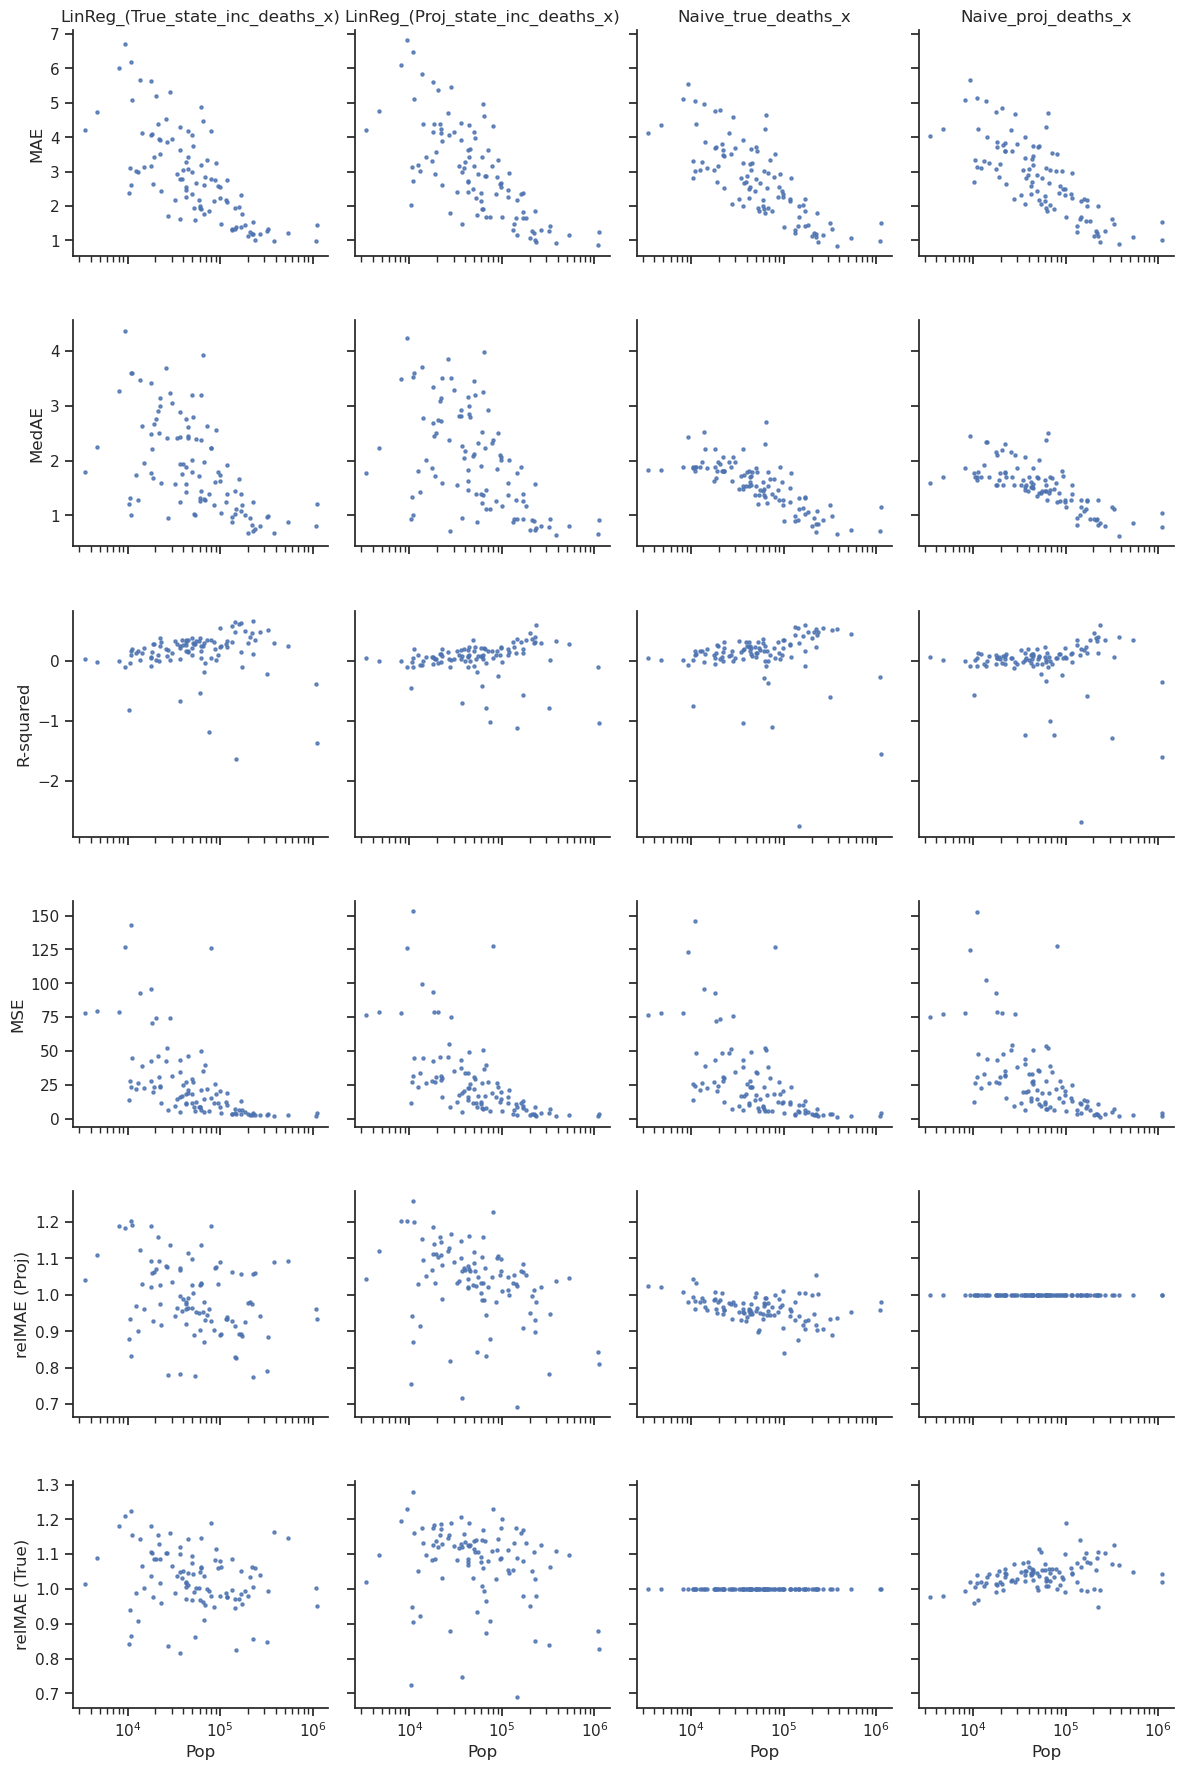

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1, style='ticks') 

g = sns.FacetGrid(df_melt, col='Model', row="Metric", sharey='row') #, margin_titles=True)
g.map(plt.scatter, 'Pop','Score', alpha=0.8, s=5).set(xscale='log')
g.set_titles(col_template='{col_name}', row_template='{row_name}',)

for i, axes_row in enumerate(g.axes):
    for j, axes_col in enumerate(axes_row):
        row, col = axes_col.get_title().split('|')
        if i == 0:
            axes_col.set_title(col.strip())
        else:
            axes_col.set_title('')
        if j == 0:
            ylabel = axes_col.get_ylabel()
            axes_col.set_ylabel(row.strip())

plt.show()

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set(font_scale=1, style='ticks') 

# from matplotlib import ticker as mtick

# metric = 'R-squared'
# model = 'Naive_true_deaths_x'
# # FIGSIZE = (8,6)
# FIGSIZE = (6,6)

# ALPHA = 0.5
# SIZE = 30
# LINEWIDTH = 0
# DPI = 100
# LABELPAD = 8
  
# plt.figure(figsize=FIGSIZE)
# # ax = sns.scatterplot(data=df_tot, x="Pop", y=metric, alpha=ALPHA, 
# #                      sizes=SIZES, linewidth=LINEWIDTH,hue='Is_state',hue_order=[True,False])

# plt_df = df_county[df_county.Model==model]
# ax = sns.scatterplot(data=plt_df, x="Pop", y=metric, alpha=ALPHA, 
#                      s=SIZE, linewidth=LINEWIDTH,
#                      c='blue',
#                      marker='.')

# # sns.scatterplot(data=df_tot[df_tot.Is_state==True], x="Pop", y=metric, alpha=0.8, 
# #                      s=80, linewidth=0.5, edgecolor='w', c='red',ax=ax, marker='*',)

# plt.xlabel('Population\n (log scale)',labelpad=LABELPAD)
# # plt.ylabel('MAE (population normed)')
# # plt.ylabel(' Mean absolute error\n(normed by population)', labelpad=LABELPAD)
# plt.ylabel(f'{metric}', labelpad=LABELPAD)

# # plt.xt

# plt.xscale('log')
# xticks = mtick.FormatStrFormatter('%d')
# plt.gca().xaxis.set_major_formatter(xticks)

# ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# sns.despine()
# plt.gcf().set_dpi(DPI)
# plt.show()